In [1]:
import m2aia as m2
import numpy as np
import pathlib
import os
# import umap
# from sklearn import cluster
import torch
import matplotlib.pyplot as plt 
# import seaborn as sea

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import Adam
import matplotlib.pyplot as plt

/home/jtfc/HS/M2aia/Sources/SpectralClustering/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#===================================
# 1. Download data
#===================================
from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639([1,2,3,4])


#===================================
# 1.1 Load image handles
#===================================
image_handles = []
for f in file_names:
    I = m2.ImzMLReader(f)
    I.Execute()
    xs = I.GetXAxis()
    image_handles.append(I)

[Tue Dec  6 12:54:59 2022 
3.260] [imzML]: data/150429_ew_section1_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 206x107
	[image dims]: 5150.000000x2675.000000
[5.142] [imzML]: data/150429_ew_section2_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 220x171
	[image dims]: 5500.000000x4275.000000
[8.020] [imzML]: data/150505_ew_section3_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 224x169
	[image dims]: 5600.000000x4225.000000
[11.143] [imzML]: data/150417_ew_section4_pos.imzML
	[pixel size]: 25.000000x25.000000
	[image area]: 197x192
	[image dims]: 4925.000000x4800.000000


In [3]:
# Examples for different neighborhood sizes
# -----------------------------------------

# dataset = m2.SpectrumDataset(image_handles, neighborhood_size=1, buffer_type="memory")
# this returns now all 9 spectra of the 3x3 neighborhood
# print("3x3 => [N=9,D]",dataset[0].shape)
# N := spectra in neighborhood
# D := spectrum depth

# or 25 spectra of the 5x5 if neighborhood_size is set to 2
# dataset = m2.SpectrumDataset(image_handles, neighborhood_size=2, buffer_type="memory")
# print("5x5 => [N=25,D]",dataset[0].shape)


In [4]:
#========================================
# 1.2 Batch generator (with neighborhood)
#========================================

# input of size (N,D) e.g. 1d convolutions expect [C,L]
# 1) Transpose: [9,D] into a [D,9] tensor
# 2) Reshape: [D,9] into a [1,D,3,3] tensor
trafo = transforms.Compose([
    transforms.Lambda(lambda x: np.transpose(x)), #=> (D,9)
    transforms.Lambda(lambda x: np.reshape(x, (1, x.shape[0], int(np.sqrt(x.shape[1])), int(np.sqrt(x.shape[1]))))), #=> (1,D,3,3)
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))])

dataset = m2.SpectrumDataset(image_handles, neighborhood_size=1, buffer_type="memory", transforms=trafo)
print("3x3 => [B,C=1,D,H=3,W=3]",dataset[0].shape)

3x3 => [B,C=1,D,H=3,W=3] torch.Size([1, 29693, 3, 3])


In [5]:
from Example_VI_Helpers import VAE, VAE_Loss
epochs = 5
batch_size = 128
latent_size = 5

m = VAE(xs.shape[-1],interim_dim=512, latent_size=latent_size)
m = m.cuda()

In [6]:
models_root = pathlib.Path('models')
models_root.mkdir(exist_ok=True)
models_path = models_root.joinpath("Example_VI.model")

if models_path.exists():
    #===================================
    # 3A Load trained model parameters
    #===================================
    state_dict = torch.load(str(models_path))
    m.load_state_dict(state_dict)
else:
    #===================================
    # 3B Model training
    #===================================
    loss = VAE_Loss(batch_size)
    loss = loss.cuda()

    optim = Adam(m.parameters())

    dataloader = DataLoader(dataset,
                            batch_size = batch_size, 
                            sampler = SubsetRandomSampler(list(range(len(dataset)))),
                            pin_memory = True,
                            drop_last = True)

    m.train()
    ## main fit steps
    total_losses = []
    for epoch in range(epochs):
        # 1. train
        epoch_losses = []
        for i, batch in enumerate(dataloader):
            
            X = batch.cuda(non_blocking=True)
            R, z, z_mean, z_log_var = m(X)
            
            loss_value = loss(X, R, z_mean, z_log_var)

            # record
            epoch_losses.append(loss_value)
            
            # backward
            optim.zero_grad()
            loss_value.backward()
            optim.step()

        # update lr
        # scheduler.step()
        losses_np = torch.tensor(epoch_losses).cpu().numpy()
        print('epoch {} loss: {}'.format(epoch, np.mean(losses_np)))

    torch.save(m.state_dict(), str(models_path))

epoch 0 loss: 27.53981590270996
epoch 1 loss: 15.589598655700684
epoch 2 loss: 14.409077644348145
epoch 3 loss: 13.78476619720459
epoch 4 loss: 13.486351013183594


In [10]:
m.eval()

N = 0
ims = []
x_dims = []
y_dims = []
for j, I in enumerate(image_handles):
    x_dim, y_dim, z_dim = I.GetShape()
    im = np.zeros((latent_size, y_dim, x_dim))
    x_dims.append(x_dim)
    y_dims.append(y_dim)
      
    for id in range(I.GetNumberOfSpectra()):
        c, z_mean, z_log_var = m.encoder(dataset[id+N][None,...].cuda())
        c = c.cpu().detach().numpy()
        x,y,z = I.GetSpectrumPosition(id)
        im[:, y, x] = c[0,:]
    N = N + I.GetNumberOfSpectra()
    ims.append(im)

No. of Obs. : 715680
Min. Value : -14.656801223754883
Max. Value : 18.085015296936035
Mean : 2.4246613970280597
Variance : 3.2868120048785436
Skewness : -0.24459299454371144


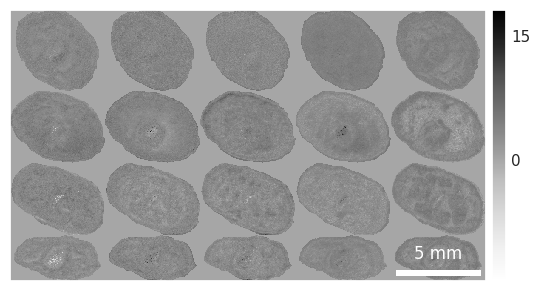

In [11]:
import seaborn_image as seaim
import seaborn as sns

sns.set_theme(style="darkgrid")
# sns.set(rc={'figure.figsize':(19,6)})
height = np.sum(y_dims)
max_im_width = np.max(x_dims)
width = max_im_width * latent_size

im_final = np.zeros((height, width))


y_pos = 0
for i, ims_temp in enumerate(ims):
    d,h,w = ims_temp.shape
    min = np.min(ims_temp)
    max = np.max(ims_temp)
    x_pos = 0
    for k in range(latent_size):
        rescaled = np.copy(ims_temp[k])
        w_delta_2 = (max_im_width-w)/2
        im_final[y_pos:y_pos + h , x_pos+int(w_delta_2):x_pos+int(w_delta_2)+w] = rescaled
        x_pos = x_pos + max_im_width
    y_pos = y_pos + h

im_final[im_final!=0] = im_final[im_final!=0]+3.5
seaim.imgplot(im_final, cmap="Greys", dx=25, units="um", describe=True)
# plt.savefig("VI.png", dpi=350)